# Anomaly detection

In this tutorial we'll be using Temporian to perform exploratory data analysis and feature engineering on the ServerMachineDataset (SMD), published as part of the [OmniAnomaly](https://github.com/NetManAIOps/OmniAnomaly/) paper, to then train a simple MLP (multi-layer perceptron, or fully-connected neural network) model on it in a supervised fashion to detect anomalies.

The ServerMachineDataset (hosted as csv files in that same repository) is a 5-week-long dataset collected from a large internet company. It is made up of system metrics (such as CPU utilization, network in and out, memory usage, etc.) from 28 different machines belonging to 3 groups.

The data has been anonymized and normalized, so there's no telling what feature means what, and it's also had its timestamps removed, so we will need to treat it as a normal time series, since we know the values are sequential, but don't know how much time has passed between each one. This makes us lose out on some of Temporian's potential - but perfectly illustrates that Temporian can be used on time series data too!

## Installation and imports

We'll be using scikit-learn's MLPClassifier as our model, since our dataset isn't too large (about 700k rows) and a simple two-layer neural network trained on CPU seems to be fit for the job.

In [1]:
%pip install temporian -q


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight

import temporian as tp

## Downloading the dataset

The dataset is comprised of 3 groups of 8, 9, and 11 machines respectively, with names `"machine-1-1"`, ..., `"machine-3-11"`.

Let's create the list of names, and then download each machine's data and labels to a `tmp/temporian_server_machine_dataset/` folder.

For the sake of time we'll only be using 3 machines in each group, but we encourage you to try it out in the complete dataset by swapping the commented line with the following one in the cell below.

In [3]:
# Create list of machine names

# machines_per_group = [8, 9, 11]
machines_per_group = [3, 3, 3]

machines = [f"machine-{group}-{id}" for group, machine in zip(range(1, 4), machines_per_group) for id in range(1, machine + 1)]

machines

['machine-1-1',
 'machine-1-2',
 'machine-1-3',
 'machine-2-1',
 'machine-2-2',
 'machine-2-3',
 'machine-3-1',
 'machine-3-2',
 'machine-3-3']

In [4]:
data_dir = Path("tmp/temporian_server_machine_dataset")

data_dir.mkdir(parents=True, exist_ok=True)

DATA = "data.csv"
LABELS = "labels.csv"

# Download the data and labels for each machine to its own folder
for machine in machines:
    print(f"Downloading data and labels for {machine}")
    
    dir = data_dir / machine
    dir.mkdir(exist_ok=True)
    
    data_path = dir / DATA
    if not data_path.exists():
        os.system(f"wget -q -O {data_path} https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/test/{machine}.txt")

    labels_path = dir / LABELS
    if not labels_path.exists():
        os.system(f"wget -q -O {labels_path} https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/test_label/{machine}.txt")

## Loading the data

We'll use pandas to load the data and perform some basic manipulation of it before transforming it into a Temporian `EventSet`.

Note that in the code below, we'll be using the loaded data's pandas index (which is a sequential one) as the `"timestamp"` column for each DataFrame. This will effectively render a time series, since each new event will be one unit of time ahead of the previous one, but it means that the timestamp column has no actual semantic meaning, and should not be used for feature engineering at all.

In [5]:
dfs = []

for machine in machines:
    dir = data_dir / machine

    # Read the data and labels
    df = pd.read_csv(dir / DATA, header=None)
    labels = pd.read_csv(dir/ LABELS, header=None)
    df = df.assign(label=labels)

    # Assign the group and machine as features (note that the group is the 8th character in "machine-1-1")
    df["group"] = machine[8]
    df["machine"] = machine
    
    # Use index as timestamps column
    df = df.reset_index(drop=False, names="timestamp")

    # Cast column names to string
    df.columns = df.columns.astype(str)

    print(f"Events in {machine}: {len(df)}")
    dfs.append(df)

df = pd.concat(dfs)
df

Events in machine-1-1: 28479
Events in machine-1-2: 23694
Events in machine-1-3: 23703
Events in machine-2-1: 23694
Events in machine-2-2: 23700
Events in machine-2-3: 23689
Events in machine-3-1: 28700
Events in machine-3-2: 23703
Events in machine-3-3: 23703


,timestamp,0,1,2,3,4,5,6,7,8,...,31,32,33,34,35,36,37,label,group,machine
0,0,0.075269,0.065678,0.070234,0.074332,0.0,0.933333,0.274011,0.0,0.031081,...,0.048893,0.000386,0.000034,0.064432,0.064500,0.000000,0.000000,0,1,machine-1-1
1,1,0.086022,0.080508,0.075808,0.076655,0.0,0.930769,0.274953,0.0,0.031081,...,0.050437,0.000386,0.000022,0.065228,0.065224,0.000000,0.000000,0,1,machine-1-1
2,2,0.075269,0.064619,0.071349,0.074332,0.0,0.928205,0.274953,0.0,0.030940,...,0.055069,0.000386,0.000045,0.067111,0.067178,0.000000,0.000000,0,1,machine-1-1
3,3,0.086022,0.048729,0.063545,0.070848,0.0,0.928205,0.273070,0.0,0.027250,...,0.051467,0.000000,0.000034,0.066676,0.066744,0.000000,0.000000,0,1,machine-1-1
4,4,0.086022,0.051907,0.062430,0.070848,0.0,0.933333,0.274011,0.0,0.030940,...,0.051467,0.000386,0.000022,0.066604,0.066671,0.000000,0.000000,0,1,machine-1-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23698,23698,0.139785,0.027030,0.025315,0.033124,0.0,0.985549,0.865359,0.0,0.008939,...,0.083451,0.108108,0.058300,0.163431,0.162907,0.163221,0.163221,0,3,machine-3-3
23699,23699,0.139785,0.018722,0.022852,0.031948,0.0,0.981936,0.864005,0.0,0.008939,...,0.082037,0.108108,0.071146,0.149656,0.149123,0.149360,0.149360,0,3,machine-3-3
23700,23700,0.139785,0.018371,0.021620,0.031164,0.0,0.977601,0.861976,0.0,0.007204,...,0.082037,0.081081,0.057312,0.149029,0.148496,0.149078,0.149078,0,3,machine-3-3
23701,23701,0.150538,0.013223,0.018883,0.029596,0.0,0.981214,0.861976,0.0,0.007605,...,0.086280,0.081081,0.036561,0.164684,0.163534,0.164264,0.164264,0,3,machine-3-3


In [6]:
df.describe()

,timestamp,0,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,label
count,223065.000000,223065.000000,223065.000000,223065.000000,223065.000000,223065.000000,223065.000000,223065.000000,223065.0,223065.000000,...,223065.000000,223065.000000,223065.000000,223065.000000,223065.000000,223065.000000,223065.000000,223065.000000,223065.000000,223065.000000
mean,12475.482474,0.157293,0.057534,0.064723,0.073195,0.195905,0.769432,0.450433,0.0,0.017383,...,0.057789,0.200988,0.108881,0.038904,0.035894,0.146026,0.148182,0.032332,0.032332,0.046507
std,7307.892531,0.148955,0.088460,0.097902,0.102525,0.335727,0.195054,0.278884,0.0,0.045717,...,0.084540,0.174399,0.137078,0.071978,0.047155,0.170754,0.170771,0.109479,0.109479,0.210580
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6196.000000,0.041237,0.002837,0.003745,0.005693,0.000000,0.638994,0.260829,0.0,0.000119,...,0.000000,0.058296,0.000000,0.000000,0.005076,0.002687,0.003036,0.000000,0.000000,0.000000
50%,12392.000000,0.110000,0.023520,0.030332,0.041748,0.000000,0.812133,0.383190,0.0,0.003512,...,0.020833,0.145740,0.068451,0.000000,0.019663,0.080189,0.081544,0.000000,0.000000,0.000000
75%,18588.000000,0.236559,0.080138,0.088292,0.101360,0.301887,0.922922,0.689052,0.0,0.022140,...,0.064516,0.314263,0.153846,0.054054,0.044466,0.216912,0.224265,0.000000,0.000000,0.000000
max,28699.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Awesome! Seems like we have 708420 rows and 42 columns in our dataset, made up of:
- 38 metric columns, which will be the main features we'll be working on with Temporian
- 2 categorical columns, which will allow us to tell apart events that belong to different machines
- 1 timestamps column
- 1 labels column

As stated previously, all metrics seem to be anonymized and normalized to [0, 1], so we won't need to take care of that ourselves.

## Creating an EventSet

Now that our data's ready, let's create a Temporian `EventSet` from it.

We'll use the `"group"` and `"machine"` columns as its index, which means that Temporian will treat the events corresponding to each machine as an independent time series when computing features off of it. This is clear when displaying the `EventSet`, which renders one table for each of our indexes' values.

Note that, since we used one column as timestamps and two others as indexes, our `EventSet` has 39 features instead of the previous 42.

In [7]:
tp.config.max_display_features = 100
tp.config.max_display_events = 5

evset = tp.from_pandas(df, indexes=["group", "machine"])

print(evset.schema.features)

evset

[('0', float64), ('1', float64), ('2', float64), ('3', float64), ('4', float64), ('5', float64), ('6', float64), ('7', float64), ('8', float64), ('9', float64), ('10', float64), ('11', float64), ('12', float64), ('13', float64), ('14', float64), ('15', float64), ('16', float64), ('17', float64), ('18', float64), ('19', float64), ('20', float64), ('21', float64), ('22', float64), ('23', float64), ('24', float64), ('25', float64), ('26', float64), ('27', float64), ('28', float64), ('29', float64), ('30', float64), ('31', float64), ('32', float64), ('33', float64), ('34', float64), ('35', float64), ('36', float64), ('37', float64), ('label', int64)]


timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,label
0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07415,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,0
1,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01473,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0
2,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.09459,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0
3,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0
4,0.08602,0.05191,0.06243,0.07085,0,0.9333,0.274,0,0.03094,0.000244,0.1027,0.1081,0.0411,0.07565,0.1191,0.1184,0,0,0.1274,0.09449,0.09817,0.07752,0.9422,0.0184,0.03411,0.01696,0,0.08093,0,0.008596,0.07093,0.05147,0.000386,2.2e-05,0.0666,0.06667,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,label
0,0.23,0.1095,0.1266,0.1338,0.2264,0.621,0.4093,0,9.3e-05,1.5e-05,0,0.00722,0,0.03696,0.003551,0.02929,0,0,0.002313,0.0108,0.005868,0.04877,0.07143,0.08159,0.2,0.07692,0,0.01994,0,0,0.04801,0,0,0.0625,0,0,0,0,0
1,0.25,0.1089,0.1271,0.134,0.2264,0.5473,0.337,0,9.3e-05,1.5e-05,0,0.009025,0,0.03926,0.004129,0.03305,0,0,0.01261,0.02618,0.01733,0.0752,0.1071,0.159,0.2,0.1538,0,0.03768,0,0,0.07518,0,0,0.05556,0,0.5,0,0,0
2,0.24,0.1228,0.1308,0.1353,0.2264,0.4784,0.2648,0,0.000653,0.000134,8e-06,0.01805,0,0.09858,0.009166,0.09242,0,0,0.1534,0.02637,0.1565,0.2137,0,0.159,0.2,0.1581,0,0.1788,0,0,0.2129,0,0,0.06944,0,0,0,0,0


Let's free up some memory by deleting the pandas DataFrame and casting all of our features to float32 (which will also make Temporian create new float32 features when applying operators on the original ones) and our label to int32.

In [8]:
del df

In [9]:
evset = evset.cast(tp.float32).cast({"label": tp.int32})
evset.schema.features

[('0', float32),
 ('1', float32),
 ('2', float32),
 ('3', float32),
 ('4', float32),
 ('5', float32),
 ('6', float32),
 ('7', float32),
 ('8', float32),
 ('9', float32),
 ('10', float32),
 ('11', float32),
 ('12', float32),
 ('13', float32),
 ('14', float32),
 ('15', float32),
 ('16', float32),
 ('17', float32),
 ('18', float32),
 ('19', float32),
 ('20', float32),
 ('21', float32),
 ('22', float32),
 ('23', float32),
 ('24', float32),
 ('25', float32),
 ('26', float32),
 ('27', float32),
 ('28', float32),
 ('29', float32),
 ('30', float32),
 ('31', float32),
 ('32', float32),
 ('33', float32),
 ('34', float32),
 ('35', float32),
 ('36', float32),
 ('37', float32),
 ('label', int32)]

## Data visualization

Let's take a look at our first index value's data. For this, we'll limit the number of plots shown by Temporian to 39, which will show us the 39 plots corresponding to the first index value.

The number of plots (351) is larger than "options.max_num_plots=39". Only the first plots will be printed.


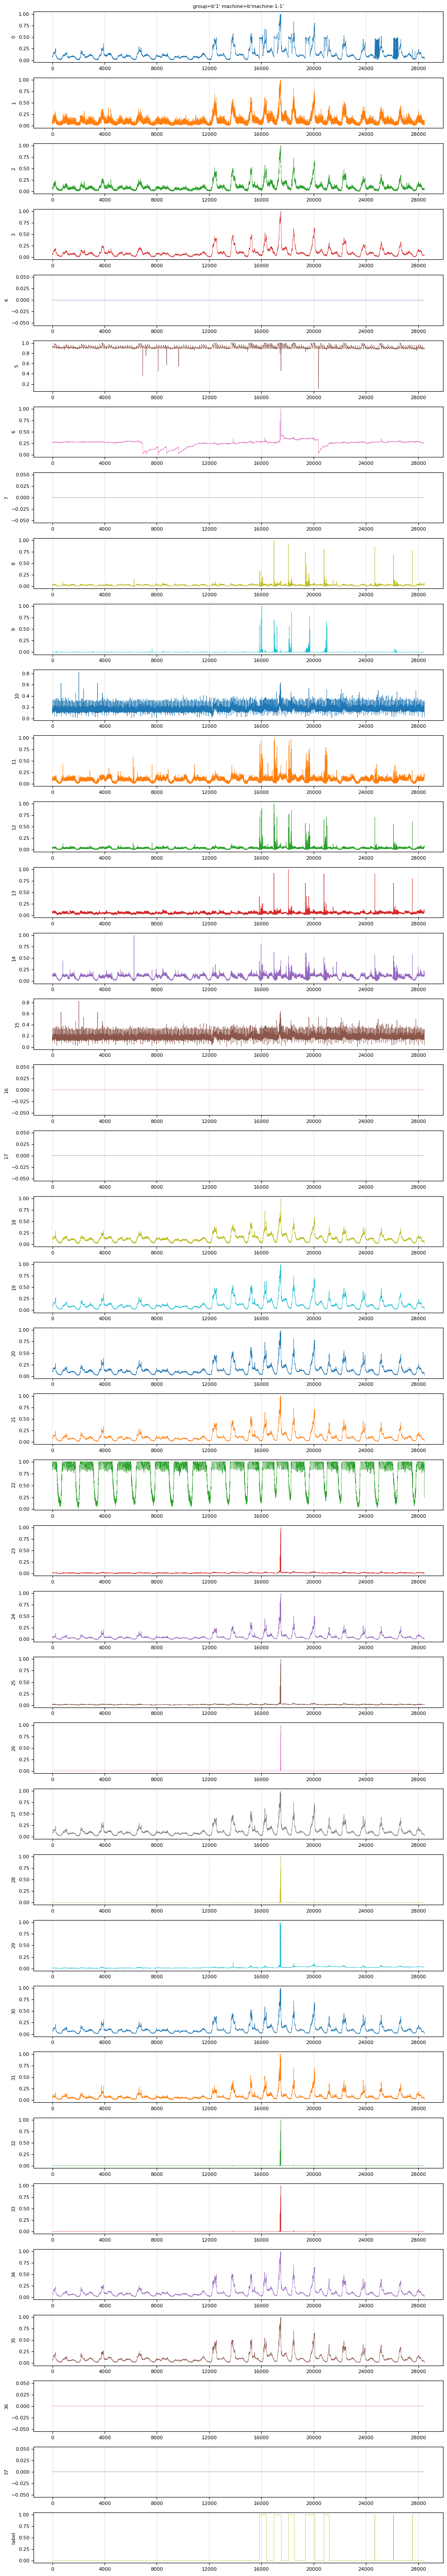

In [10]:
evset.plot(max_num_plots=39)

Great! A lot to unpack here:
- It seems to be easy to understand when an anomaly occurs (label takes value of 1) by looking at the other plots. Features 11 to 14, for example, seem to be very correlated to the label.
- The data seems to have some periodicity to it.
- Some features seem empty, and we could evaluate dropping them if needed.

## Data preparation

To prepare our data to train a model on it, let's start off by separating the features from the labels.

In [11]:
feature_names = evset.schema.feature_names()
feature_names.remove('label')

raw_features = evset[feature_names]
labels = evset[['label']]

print("Raw features:", raw_features.schema)
print("Labels:", labels.schema)

Raw features: features: [('0', float32), ('1', float32), ('2', float32), ('3', float32), ('4', float32), ('5', float32), ('6', float32), ('7', float32), ('8', float32), ('9', float32), ('10', float32), ('11', float32), ('12', float32), ('13', float32), ('14', float32), ('15', float32), ('16', float32), ('17', float32), ('18', float32), ('19', float32), ('20', float32), ('21', float32), ('22', float32), ('23', float32), ('24', float32), ('25', float32), ('26', float32), ('27', float32), ('28', float32), ('29', float32), ('30', float32), ('31', float32), ('32', float32), ('33', float32), ('34', float32), ('35', float32), ('36', float32), ('37', float32)]
indexes: [('group', str_), ('machine', str_)]
is_unix_timestamp: False

Labels: features: [('label', int32)]
indexes: [('group', str_), ('machine', str_)]
is_unix_timestamp: False



Next, we'll need to split our dataset into train and testing sets, which we'll use an 80/20 split for.

We'll be creating reusable functions for each step, since we'll do some iteration over the `feature engineering -> training -> evaluation cycle`.

In [12]:
CATEGORICAL_COLS = ["group", "machine"]
DROP_COLS = CATEGORICAL_COLS + ["timestamp"]

def make_datasets(X: tp.EventSet, y: tp.EventSet):
    """Splits X and y into train and test sets and transforms categorical features into one-hot-encoded features."""

    # Compute the timestamp that corresponds to 80% of the data, and use it to split the data
    last_train_timestamp = int(len(X.get_arbitrary_index_data()) * 0.8)
    timestamp = X.timestamps()
    X_train = X.filter(timestamp <= last_train_timestamp)
    X_test = X.filter(timestamp > last_train_timestamp)
    y_train = y.filter(timestamp <= last_train_timestamp)
    y_test = y.filter(timestamp > last_train_timestamp)

    # Using a DataFrame for these last few steps to feed into the scikit-learn model
    # Note that even though the raw data has no NaNs, we will create some during our feature engineering
    X_train = tp.to_pandas(X_train).fillna(-1)
    
    # Define and fit the one-hot encoder for our categorical features
    encoder = OneHotEncoder(sparse_output=False)
    train_encoded = encoder.fit_transform(X_train[CATEGORICAL_COLS])

    # Replace timestamp and categorical columns with the new encoded ones
    X_train = X_train.drop(columns=DROP_COLS)
    X_train = np.concatenate([X_train.to_numpy(), train_encoded], axis=1)

    # Repeat process for test set
    X_test = tp.to_pandas(X_test).fillna(-1)
    test_encoded = encoder.transform(X_test[CATEGORICAL_COLS])
    X_test = X_test.drop(columns=DROP_COLS)
    X_test = np.concatenate([X_test.to_numpy(), test_encoded], axis=1)

    # Cast our labels and remove timestamp and categorical columns
    y_train = tp.to_pandas(y_train).drop(columns=DROP_COLS).squeeze()
    y_test = tp.to_pandas(y_test).drop(columns=DROP_COLS).squeeze()

    print("Number of samples in train set", len(X_train))
    print("Number of positive (anomalous) samples in train set", y_train.sum())
    print("Number of samples in test set", len(X_test))
    print("Number of positive (anomalous) samples in test set", y_test.sum())

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = make_datasets(raw_features, labels)

Number of samples in train set 170667
Number of positive (anomalous) samples in train set 7186
Number of samples in test set 52398
Number of positive (anomalous) samples in test set 3188


Those numbers look alright. However, we seem to be dealing with a fairly unbalanced dataset, with the positive labels in the training set accounting for only 3% of the total. We'll remember to take that into account when evaluating our model.

## Training

Having done all that work to prepare our data, all that remains is to train our MLP. A small network will do the trick.

In [13]:
def train(X_train, y_train):
    model = MLPClassifier(
        hidden_layer_sizes=(64, 16),
        learning_rate='adaptive',
        learning_rate_init=0.0001,
        batch_size=512,
        tol=0.001,
        n_iter_no_change=3,
        random_state=0,
        verbose=True,
    )
    model.fit(X_train, y_train)
    return model

model = train(X_train, y_train)

Iteration 1, loss = 0.35762397
Iteration 2, loss = 0.19198969
Iteration 3, loss = 0.17113193
Iteration 4, loss = 0.15829303
Iteration 5, loss = 0.14980958
Iteration 6, loss = 0.14465439
Iteration 7, loss = 0.14051211
Iteration 8, loss = 0.13632020
Iteration 9, loss = 0.13243515
Iteration 10, loss = 0.12874860
Iteration 11, loss = 0.12537540
Iteration 12, loss = 0.12237949
Iteration 13, loss = 0.11961306
Iteration 14, loss = 0.11716857
Iteration 15, loss = 0.11497058
Iteration 16, loss = 0.11302140
Iteration 17, loss = 0.11129302
Iteration 18, loss = 0.10975305
Iteration 19, loss = 0.10831662
Iteration 20, loss = 0.10700486
Iteration 21, loss = 0.10579782
Iteration 22, loss = 0.10478984
Iteration 23, loss = 0.10378929
Iteration 24, loss = 0.10297079
Iteration 25, loss = 0.10216076
Iteration 26, loss = 0.10148325
Iteration 27, loss = 0.10084022
Training loss did not improve more than tol=0.001000 for 3 consecutive epochs. Stopping.


## Evaluation

As we noticed previously, the dataset is very unbalanced. The MLPClassifier returns the mean accuracy over each possible class (0 or 1 in our case) in `.score()`, which would make it very hard to assess how well we're doing on the cases we value the most. Luckily, that same function accepts a `sample_weight` parameter, which we'll use to balance out the impact of each class' accuracy on the final score.

In [14]:
# Compute class weights (we only need to do this once, since it won't be changing while we iterate over feature engineering)
classes = y_train.unique()
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))

print("Class weights:", class_weights)

Class weights: {0: 0.5219780891969097, 1: 11.87496521013081}


Train score: 0.6350114495083008
Test score: 0.5773619538721612
Train predictions
Test predictions


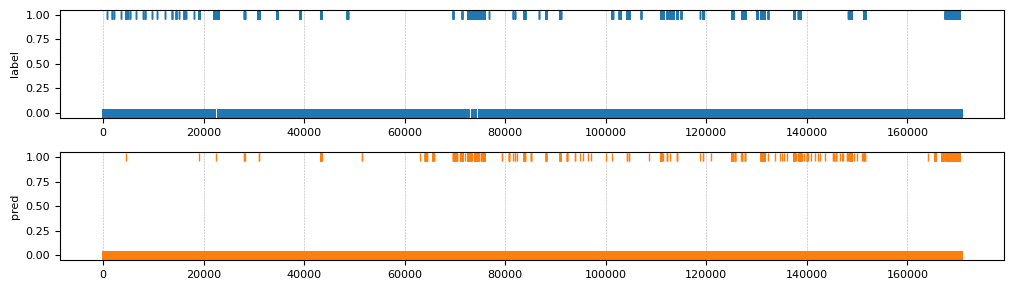

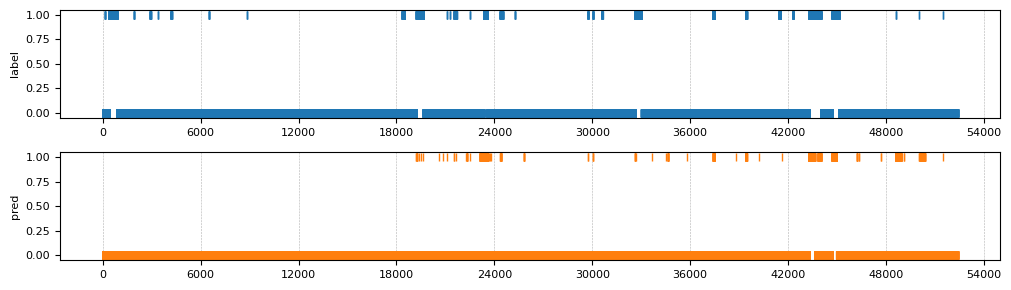

In [15]:
figsize=(20,3)

def eval(model, X_train, y_train, X_test, y_test):
    """Evaluates a model on its training data and unseen test data, computing accuracy score and plotting ground truth vs predictions."""
    # Compute sample weights based on class weights
    train_sample_weights = compute_sample_weight(class_weights, y_train)
    test_sample_weights = compute_sample_weight(class_weights, y_test)
    
    # Compute scores
    print("Train score:", model.score(X_train, y_train, sample_weight=train_sample_weights))
    print("Test score:", model.score(X_test, y_test, sample_weight=test_sample_weights))

    # Get predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    print("Train predictions")
    tp.event_set(timestamps=y_train.index, features={"label": y_train, "pred": train_preds}).plot(style="vline")

    print("Test predictions")
    tp.event_set(timestamps=y_test.index, features={"label": y_test, "pred": test_preds}).plot(style="vline")

eval(model, X_train, y_train, X_test, y_test)

That's pretty decent for a first try. Our model seems to be learning, but not overfitting, on its training data. There's plenty of room for improvement though, so let's kick off the feature engineering!

## Feature engineering

### Lag features

Right now our model only has access to each event's raw metric values, + the group and machine that it belongs to. This means that it has no knowledge of the **context** an event is happening on - some values might have been completely normal when the measuring started, but anomalous a couple of weeks later, e.g. if that machine's usage went up as a whole during that time and its baseline usage now stands much higher than it used to.

To combat this, we'll start by lagging the values of each feature. In doing this, we're providing the model (some) information about that the metric's value looked like a couple of steps into the past.

In [16]:
lag_features = []

# Lag each raw feature by 1, 2, ..., 10 steps
for window in range(1, 11):
    lag_features.append(raw_features.lag(window).resample(raw_features).prefix(f"lag_{window}_"))

features = tp.glue(raw_features, *lag_features)
features

timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,lag_1_0,lag_1_1,lag_1_2,lag_1_3,lag_1_4,lag_1_5,lag_1_6,lag_1_7,lag_1_8,lag_1_9,lag_1_10,lag_1_11,lag_1_12,lag_1_13,lag_1_14,lag_1_15,lag_1_16,lag_1_17,lag_1_18,lag_1_19,lag_1_20,lag_1_21,lag_1_22,lag_1_23,lag_1_24,lag_1_25,lag_1_26,lag_1_27,lag_1_28,lag_1_29,lag_1_30,lag_1_31,lag_1_32,lag_1_33,lag_1_34,lag_1_35,lag_1_36,lag_1_37,lag_2_0,lag_2_1,lag_2_2,lag_2_3,lag_2_4,lag_2_5,lag_2_6,lag_2_7,lag_2_8,lag_2_9,lag_2_10,lag_2_11,lag_2_12,lag_2_13,lag_2_14,lag_2_15,lag_2_16,lag_2_17,lag_2_18,lag_2_19,lag_2_20,lag_2_21,lag_2_22,lag_2_23,…
0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
1,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
2,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,…
3,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,…
4,0.08602,0.05191,0.06243,0.07085,0,0.9333,0.274,0,0.03094,0.000244,0.1027,0.1081,0.0411,0.07565,0.1191,0.1184,0,0,0.1274,0.09449,0.09817,0.07752,0.9422,0.0184,0.03411,0.01696,0,0.08093,0,0.008596,0.07093,0.05147,0.000386,2.2e-05,0.0666,0.06667,0,0,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,…
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,3

Let's take a look at any metric alongside its lagged values. We'll select a small time window, to be able to appreciate how the time series moves to the right as the number of lagged timesteps increases.

The number of plots (99) is larger than "options.max_num_plots=20". Only the first plots will be printed.


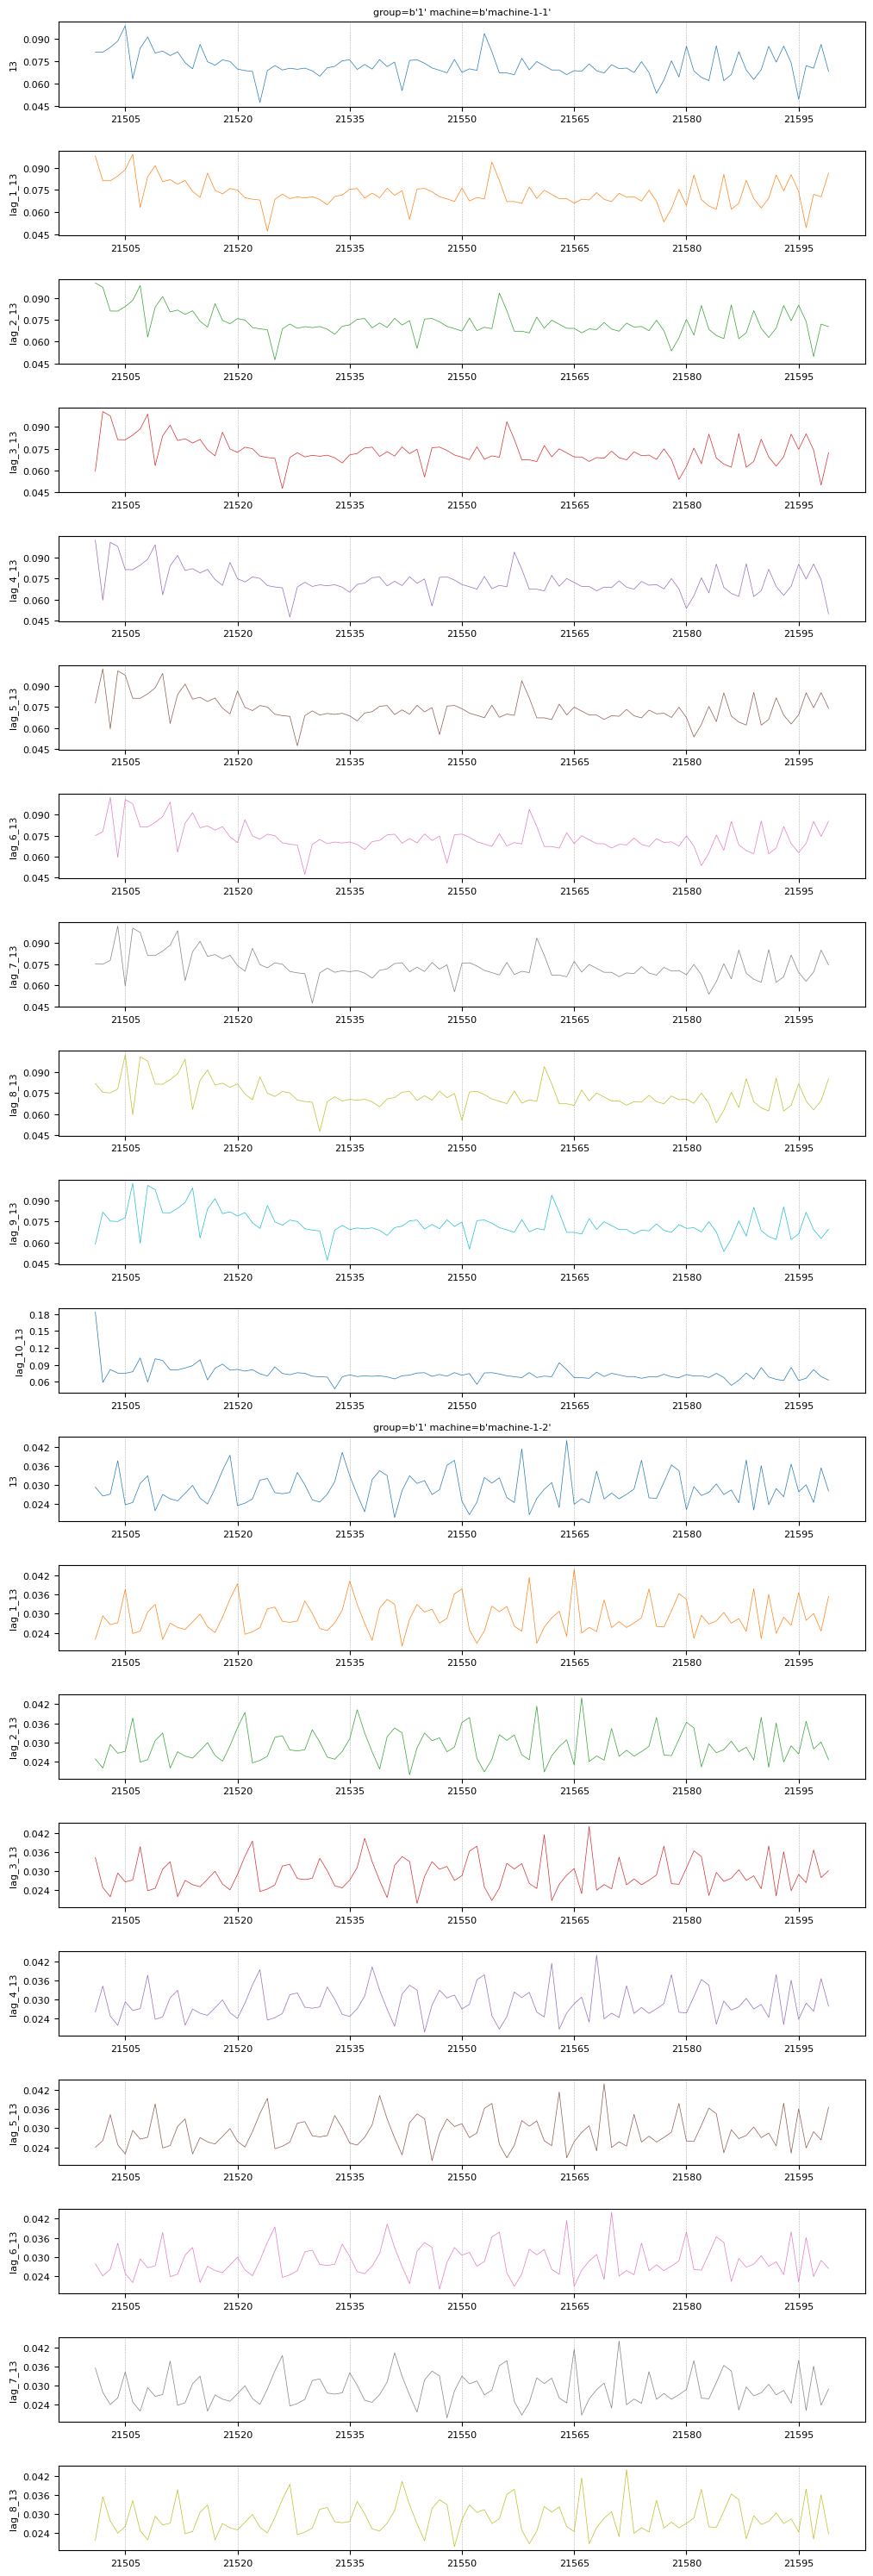

In [17]:
f13_lags = features[["13"] + [f"lag_{i}_13" for i in range(1, 11)]]
timestamps = f13_lags.timestamps()
f13_lags = f13_lags.filter((timestamps > 21500) & (timestamps < 21600))
f13_lags.plot()

Time to train and evaluate a new model with these new features! 

Number of samples in train set 170667
Number of positive (anomalous) samples in train set 7186
Number of samples in test set 52398
Number of positive (anomalous) samples in test set 3188
Iteration 1, loss = 0.26836240
Iteration 2, loss = 0.16748997
Iteration 3, loss = 0.14817471
Iteration 4, loss = 0.13660890
Iteration 5, loss = 0.12654223
Iteration 6, loss = 0.11901831
Iteration 7, loss = 0.11333389
Iteration 8, loss = 0.10884045
Iteration 9, loss = 0.10498634
Iteration 10, loss = 0.10173576
Iteration 11, loss = 0.09892545
Iteration 12, loss = 0.09629730
Iteration 13, loss = 0.09404799
Iteration 14, loss = 0.09212120
Iteration 15, loss = 0.09032455
Iteration 16, loss = 0.08873757
Iteration 17, loss = 0.08747842
Iteration 18, loss = 0.08614309
Iteration 19, loss = 0.08491832
Iteration 20, loss = 0.08392474
Iteration 21, loss = 0.08277086
Iteration 22, loss = 0.08168309
Iteration 23, loss = 0.08081591
Iteration 24, loss = 0.07996610
Iteration 25, loss = 0.07889448
Iteration 26, loss = 0

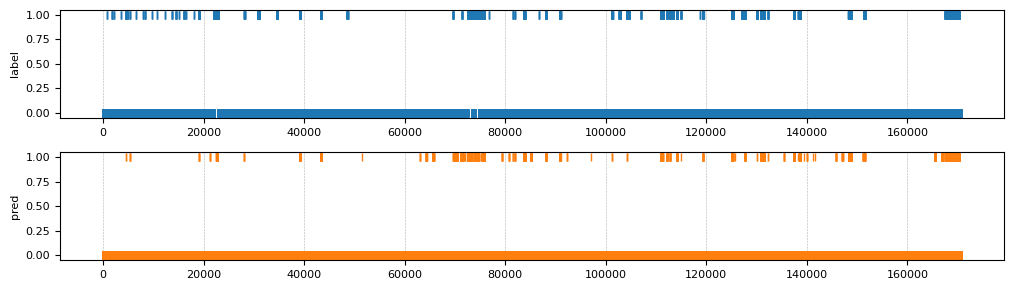

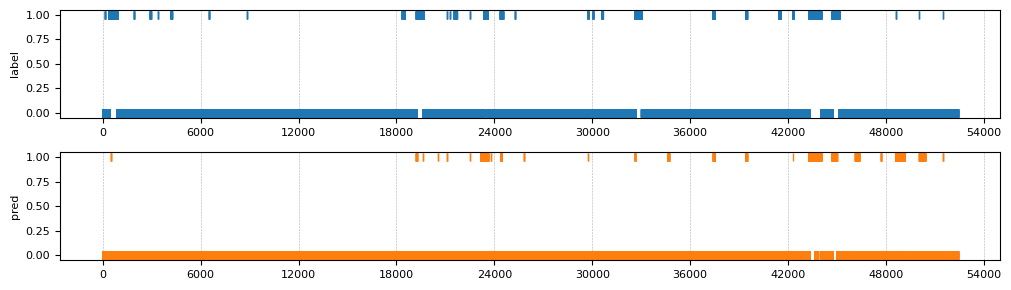

In [18]:
X_train, y_train, X_test, y_test = make_datasets(features, labels)
model = train(X_train, y_train)
eval(model, X_train, y_train, X_test, y_test)

### Moving statistic features

The improvement in performance given by the lag features was significant!

However, although useful, the raw lagged values aren't enough to provide the model a comprehensive look at each value's past context. Note also that we only gave it a glimpse of 10 steps into the past, and each time series has more than 24k values.

This is where **moving statistics** can come in handy. Instead of a list of raw values, we can provide the model an aggregation of each metric's values over the last N timesteps. For example, we can tell it what the maximum and minimum value of a metric were in the last steps, of what the standard deviation was in the last 1000. 

Luckily, Temporian's window operators make this a breeze.

In [19]:
moving_statistic_features = []

# Compute the moving average, standard deviation, max, and min over different windows
for window in [20, 200, 2000]:
    moving_statistic_features.append(raw_features.simple_moving_average(window).prefix(f"avg_{window}_"))
    moving_statistic_features.append(raw_features.moving_standard_deviation(window).prefix(f"std_{window}_"))
    moving_statistic_features.append(raw_features.moving_max(window).prefix(f"max_{window}_"))
    moving_statistic_features.append(raw_features.moving_min(window).prefix(f"min_{window}_"))

features = tp.glue(raw_features, *lag_features, *moving_statistic_features)
features

timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,lag_1_0,lag_1_1,lag_1_2,lag_1_3,lag_1_4,lag_1_5,lag_1_6,lag_1_7,lag_1_8,lag_1_9,lag_1_10,lag_1_11,lag_1_12,lag_1_13,lag_1_14,lag_1_15,lag_1_16,lag_1_17,lag_1_18,lag_1_19,lag_1_20,lag_1_21,lag_1_22,lag_1_23,lag_1_24,lag_1_25,lag_1_26,lag_1_27,lag_1_28,lag_1_29,lag_1_30,lag_1_31,lag_1_32,lag_1_33,lag_1_34,lag_1_35,lag_1_36,lag_1_37,lag_2_0,lag_2_1,lag_2_2,lag_2_3,lag_2_4,lag_2_5,lag_2_6,lag_2_7,lag_2_8,lag_2_9,lag_2_10,lag_2_11,lag_2_12,lag_2_13,lag_2_14,lag_2_15,lag_2_16,lag_2_17,lag_2_18,lag_2_19,lag_2_20,lag_2_21,lag_2_22,lag_2_23,…
0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
1,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
2,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,…
3,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,…
4,0.08602,0.05191,0.06243,0.07085,0,0.9333,0.274,0,0.03094,0.000244,0.1027,0.1081,0.0411,0.07565,0.1191,0.1184,0,0,0.1274,0.09449,0.09817,0.07752,0.9422,0.0184,0.03411,0.01696,0,0.08093,0,0.008596,0.07093,0.05147,0.000386,2.2e-05,0.0666,0.06667,0,0,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,…
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,3

Taking a look at some of the generated features:

The number of plots (45) is larger than "options.max_num_plots=20". Only the first plots will be printed.


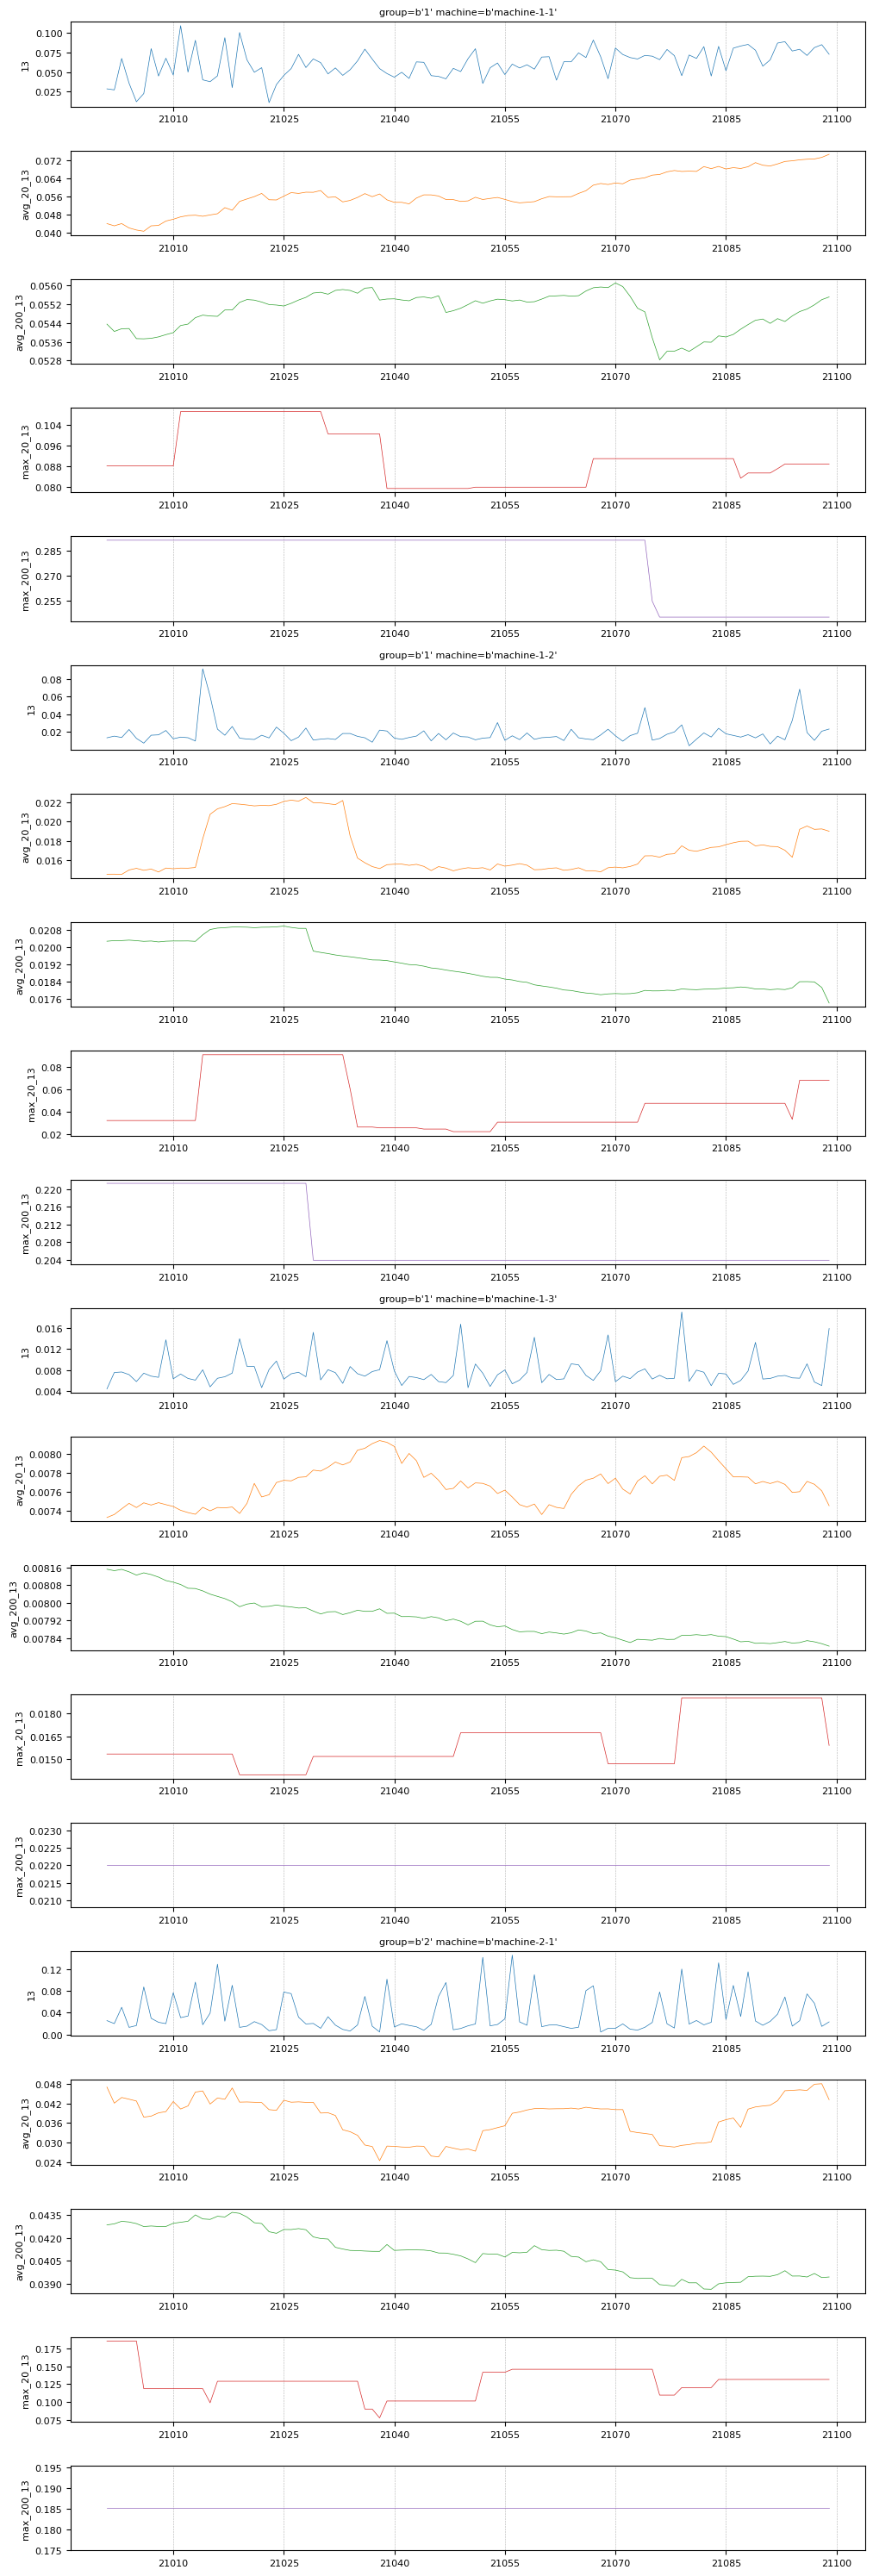

In [20]:
f13_stats = features[["13", "avg_20_13", "avg_200_13", "max_20_13", "max_200_13"]]
timestamps = f13_stats.timestamps()
f13_stats = f13_stats.filter((timestamps > 21000) & (timestamps < 21100))
f13_stats.plot()

Number of samples in train set 170667
Number of positive (anomalous) samples in train set 7186
Number of samples in test set 52398
Number of positive (anomalous) samples in test set 3188
Iteration 1, loss = 0.21733885
Iteration 2, loss = 0.13700396
Iteration 3, loss = 0.10732090
Iteration 4, loss = 0.08874875
Iteration 5, loss = 0.07546138
Iteration 6, loss = 0.06413285
Iteration 7, loss = 0.05557835
Iteration 8, loss = 0.04873534
Iteration 9, loss = 0.04378912
Iteration 10, loss = 0.03967100
Iteration 11, loss = 0.03651742
Iteration 12, loss = 0.03402103
Iteration 13, loss = 0.03181854
Iteration 14, loss = 0.02990912
Iteration 15, loss = 0.02830940
Iteration 16, loss = 0.02705818
Iteration 17, loss = 0.02552236
Iteration 18, loss = 0.02439079
Iteration 19, loss = 0.02345999
Iteration 20, loss = 0.02249410
Iteration 21, loss = 0.02164874
Iteration 22, loss = 0.02067219
Training loss did not improve more than tol=0.001000 for 3 consecutive epochs. Stopping.
Train score: 0.94025088344063

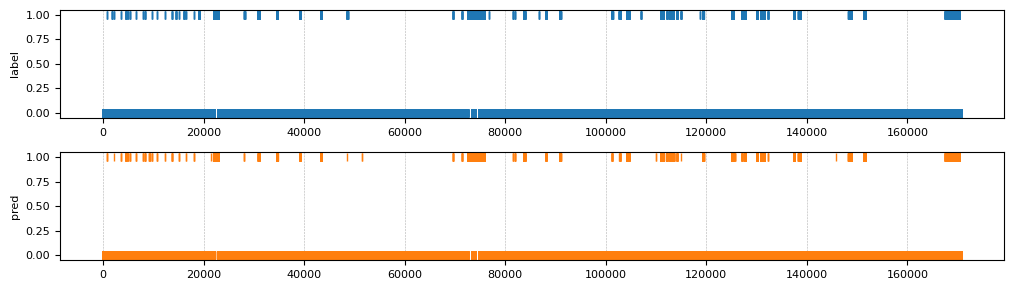

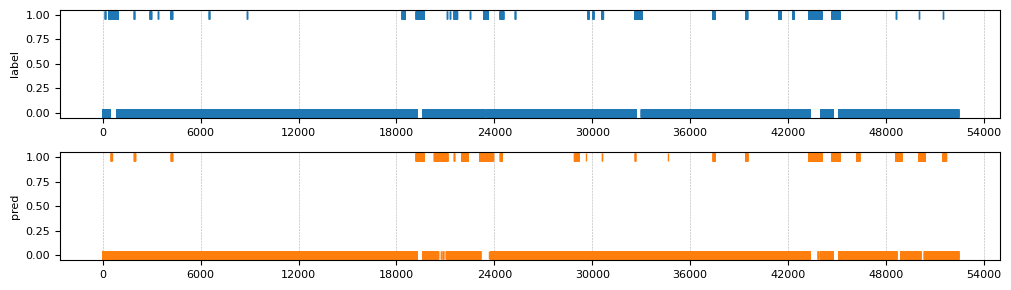

In [21]:
X_train, y_train, X_test, y_test = make_datasets(features, labels)
model = train(X_train, y_train)
eval(model, X_train, y_train, X_test, y_test)

That's quite an improvement! Our model seems to not be generalizing as well as before, but these new features have definitely helped it learn to recognize anomalies.

### Per-group features

As of now, each machine's events only have access to that same machine's lagged values and moving statistics.

In some cases, giving the model information about each entity's parent can be helpful. In this case, that could mean for example providing information to each machine's events about the average value of each metric in its group (remember that each machine belongs to one of 3 groups). In this case we don't know the semantics of what a group means and this could be of little to no use - but in other contexts it can be incredibly useful, such as feeding a store's aggregated sales to each product, or one country's music preferences to each user in it!

To compute these hierarchically-aggregated features, Temporian's indexes and `.propagate()` operator are incredibly powerful.

In [22]:
grouped_features = []

# Drop the "machine" index to obtain an EventSet indexed by group only
# Operators will now operate on each group, instead of on each machine!
grouped_raw_features = raw_features.drop_index("machine", keep=False)

grouped_features.append(grouped_raw_features.moving_sum(1).prefix("gr_sum_").propagate(raw_features, resample=True))
grouped_features.append(grouped_raw_features.simple_moving_average(10).prefix("gr_sma_10_").propagate(raw_features, resample=True))
grouped_features.append(grouped_raw_features.simple_moving_average(100).prefix("gr_sma_100_").propagate(raw_features, resample=True))
grouped_features.append(grouped_raw_features.simple_moving_average(1000).prefix("gr_sma_1000_").propagate(raw_features, resample=True))

features = tp.glue(raw_features, *lag_features, *moving_statistic_features, *grouped_features)
features

timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,lag_1_0,lag_1_1,lag_1_2,lag_1_3,lag_1_4,lag_1_5,lag_1_6,lag_1_7,lag_1_8,lag_1_9,lag_1_10,lag_1_11,lag_1_12,lag_1_13,lag_1_14,lag_1_15,lag_1_16,lag_1_17,lag_1_18,lag_1_19,lag_1_20,lag_1_21,lag_1_22,lag_1_23,lag_1_24,lag_1_25,lag_1_26,lag_1_27,lag_1_28,lag_1_29,lag_1_30,lag_1_31,lag_1_32,lag_1_33,lag_1_34,lag_1_35,lag_1_36,lag_1_37,lag_2_0,lag_2_1,lag_2_2,lag_2_3,lag_2_4,lag_2_5,lag_2_6,lag_2_7,lag_2_8,lag_2_9,lag_2_10,lag_2_11,lag_2_12,lag_2_13,lag_2_14,lag_2_15,lag_2_16,lag_2_17,lag_2_18,lag_2_19,lag_2_20,lag_2_21,lag_2_22,lag_2_23,…
0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
1,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
2,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,…
3,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,…
4,0.08602,0.05191,0.06243,0.07085,0,0.9333,0.274,0,0.03094,0.000244,0.1027,0.1081,0.0411,0.07565,0.1191,0.1184,0,0,0.1274,0.09449,0.09817,0.07752,0.9422,0.0184,0.03411,0.01696,0,0.08093,0,0.008596,0.07093,0.05147,0.000386,2.2e-05,0.0666,0.06667,0,0,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,…
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,3

Number of samples in train set 170667
Number of positive (anomalous) samples in train set 7186
Number of samples in test set 52398
Number of positive (anomalous) samples in test set 3188
Iteration 1, loss = 0.34921445
Iteration 2, loss = 0.14615578
Iteration 3, loss = 0.11712329
Iteration 4, loss = 0.10027315
Iteration 5, loss = 0.08660832
Iteration 6, loss = 0.07493218
Iteration 7, loss = 0.06539237
Iteration 8, loss = 0.05848477
Iteration 9, loss = 0.05307936
Iteration 10, loss = 0.04870466
Iteration 11, loss = 0.04500330
Iteration 12, loss = 0.04192038
Iteration 13, loss = 0.03925250
Iteration 14, loss = 0.03700998
Iteration 15, loss = 0.03483423
Iteration 16, loss = 0.03309578
Iteration 17, loss = 0.03143816
Iteration 18, loss = 0.02976545
Iteration 19, loss = 0.02842013
Iteration 20, loss = 0.02715795
Iteration 21, loss = 0.02588653
Iteration 22, loss = 0.02489748
Iteration 23, loss = 0.02367352
Iteration 24, loss = 0.02287543
Iteration 25, loss = 0.02200763
Iteration 26, loss = 0

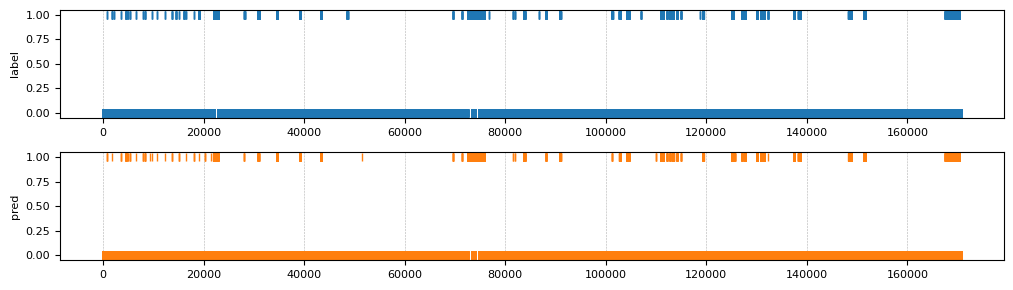

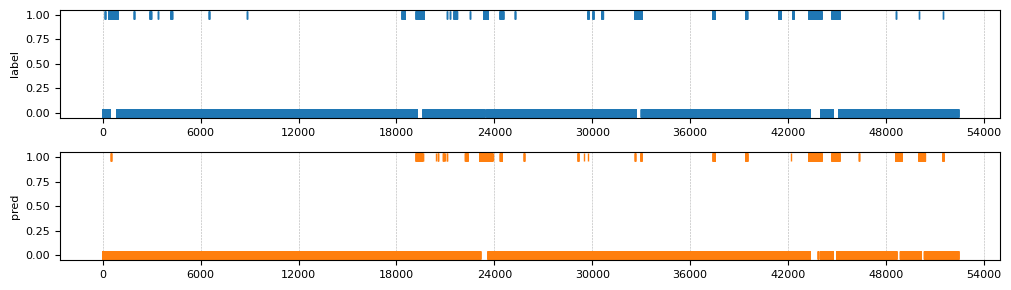

In [23]:
X_train, y_train, X_test, y_test = make_datasets(features, labels)
model = train(X_train, y_train)
eval(model, X_train, y_train, X_test, y_test)

Doesn't seem to have been of much use.

## Wrapping up

In this notebook we learned how to perform feature engineering and visualization using Temporian, applying it to a real-world anomaly detection use case.

There's some further work that could be done in this problem! Here's some ideas:
- Train a larger model! Our two-layer MLP has been alright, but a more capable model would definitely be able to find new patterns in the data - although it'll probably require some extra regularization work too
- Use the dataset's [unlabeled train data](https://github.com/NetManAIOps/OmniAnomaly/tree/master/ServerMachineDataset/train) to craft an unsupervised solution, and then test it on the labeled test data we used for this notebook.
- Keep adding new features! As we demonstrated, a very simple model can go a long way if the correct features are provided to it. This is where Temporian shines - check out the full list of operators in the [API Reference](https://temporian.readthedocs.io/en/stable/reference/#operators) for some inspiration!